# Семинар 8: задачи на графах

## Вступление
Графы часто возникают в представлении различных данных: социальные сети, интернет страницы, маршруты на картах и так далее. Сегодня мы разберём две задачи: оценка важности веб-страниц при помощи PageRank и построение графовой свёрточной сети (GNN).

### План семинара
1. PageRank
   1. Основные понятия про графы
   2. Random surfer
   3. Проблемы подхода
2. GraphSAGE

## 1. PageRank
Вполне естественно рассматривать интернет как ориентированный граф, где узлы — это страницы, а ребра — гиперссылки. Допустим, в Интернете всего 4 страницы, и возьмем, к примеру, следующий веб-граф.

### 1.1 Основные понятия про графы

In [1]:
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

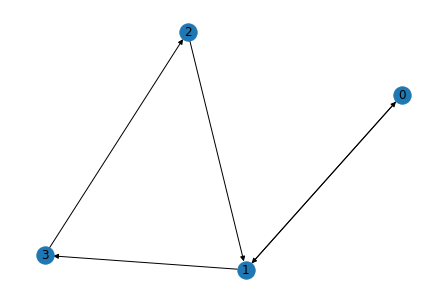

In [2]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(1, 3), (3, 2), (2, 1), (1, 0), (0, 1)])
nx.draw(G, with_labels=True)

__Матрица смежности__

In [3]:
A = np.array(nx.adjacency_matrix(G).todense()).T
A

array([[0, 1, 0, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

__Матрица степеней__

In [4]:
degrees = [val // 2 for (node, val) in G.degree()]
D = np.diag(degrees)
D

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

Эта матрица представляет количество исходящих ребер из каждого узла. Нормируем матрицу смежности А по степени каждого узла, и получим переходную матрицу M, которая представляет вероятность перехода в каждом узле.

__Матрица перехода__
$$M = AD^{-1} $$

In [5]:
M = A @ np.linalg.inv(D)
M

array([[0. , 0.5, 0. , 0. ],
       [1. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. ],
       [0. , 0.5, 0. , 0. ]])

In [6]:
def calculate_transition_matrix(G):
    A = np.array(nx.adjacency_matrix(G).todense()).T
    degrees = [val // 2 for (node, val) in G.degree()]
    D = np.diag(degrees)
    M = A @ np.linalg.inv(D)
    return M

Каждый столбец М удовлетворяет аксиомам вероятности: для каждого столбца все элементы неотрицательны, а сумма равна 1.

### 1.2 Random surfer

Рассмотрим случайного пользователя, который исследует интернет, просто нажимая на гиперссылки на текущей странице случайным образом. Например, если случайный посетитель просматривает страницу 2, следующей страницей будет страница 0 или 3 с вероятностью 50 на 50. Как часто этот случайный посетитель заходит на каждую страницу? Пусть $v$ — распределение вероятностей по 4 страницам, инициализированное как равномерное распределение. Мы можем получить ответ, умножив матрицу перехода $М$ слева итеративно. Таким образом мы получим цепь Маркова — процесс, характеризующийся состоянием в текущий момент времени.

$$v_{k+1} = Mv_k$$

In [7]:
initial = np.ones(len(G.nodes())) / len(G.nodes())

initial

array([0.25, 0.25, 0.25, 0.25])

In [8]:
initial = np.ones(len(G.nodes())) / len(G.nodes())
print(0, initial)
for i in range(1, 20):
    initial = M @ initial
    print(i, np.round(initial, 3))

0 [0.25 0.25 0.25 0.25]
1 [0.125 0.5   0.25  0.125]
2 [0.25  0.375 0.125 0.25 ]
3 [0.188 0.375 0.25  0.188]
4 [0.188 0.438 0.188 0.188]
5 [0.219 0.375 0.188 0.219]
6 [0.188 0.406 0.219 0.188]
7 [0.203 0.406 0.188 0.203]
8 [0.203 0.391 0.203 0.203]
9 [0.195 0.406 0.203 0.195]
10 [0.203 0.398 0.195 0.203]
11 [0.199 0.398 0.203 0.199]
12 [0.199 0.402 0.199 0.199]
13 [0.201 0.398 0.199 0.201]
14 [0.199 0.4   0.201 0.199]
15 [0.2   0.4   0.199 0.2  ]
16 [0.2   0.399 0.2   0.2  ]
17 [0.2 0.4 0.2 0.2]
18 [0.2 0.4 0.2 0.2]
19 [0.2 0.4 0.2 0.2]
20 [0.2 0.4 0.2 0.2]
21 [0.2 0.4 0.2 0.2]
22 [0.2 0.4 0.2 0.2]
23 [0.2 0.4 0.2 0.2]
24 [0.2 0.4 0.2 0.2]
25 [0.2 0.4 0.2 0.2]
26 [0.2 0.4 0.2 0.2]
27 [0.2 0.4 0.2 0.2]
28 [0.2 0.4 0.2 0.2]
29 [0.2 0.4 0.2 0.2]
30 [0.2 0.4 0.2 0.2]
31 [0.2 0.4 0.2 0.2]
32 [0.2 0.4 0.2 0.2]
33 [0.2 0.4 0.2 0.2]
34 [0.2 0.4 0.2 0.2]
35 [0.2 0.4 0.2 0.2]
36 [0.2 0.4 0.2 0.2]
37 [0.2 0.4 0.2 0.2]
38 [0.2 0.4 0.2 0.2]
39 [0.2 0.4 0.2 0.2]
40 [0.2 0.4 0.2 0.2]
41 [0.2 0.4 0.2 0

Наконец мы подошли к ответу. Случайный пользователь просматривает страницу 1 в течение 40% времени и страницы 0, 2 и 3 в течение 20% времени. Эта конечная вероятность называется PageRank (некоторые технические детали приведены ниже) и служит мерой важности для веб-страниц. Обратите внимание, что приведенное выше итеративное умножение сходится к постоянному вектору PageRank $v$. Это эквивалентно вычислению собственного вектора, соответствующего собственному значению 1, степенным методом  (a.k.a. **power iteration**). Для понимания, что происходит, также посчитаем pagerank вручную.

In [9]:
iteration_counter = 0


def initialize_node_points(G):
    initial = [1 / G.number_of_nodes() for _ in range(G.number_of_nodes())]
    return G, initial


def update_node_points(G, previous_node_points):
    global iteration_counter
    iteration_counter += 1
    updated_node_points = [0 for _ in range(G.number_of_nodes())]
    for node in G.nodes():
        node_references = G.out_edges(node)
        if len(node_references) == 0:
            updated_node_points[node] += previous_node_points[node]
        else:
            share = previous_node_points[node] / len(node_references)
            for each_reference in node_references:
                updated_node_points[each_reference[1]] += share
    return updated_node_points, iteration_counter


def keep_updating_until_convergence(G, initial_node_points):
    convergence_value = 0.00001
    previous_node_points = initial_node_points
    while True:
        updated_node_points, iteration_counter = update_node_points(
            G, previous_node_points
        )
        for index in range(G.number_of_nodes()):
            if (
                abs(updated_node_points[index] - previous_node_points[index])
                > convergence_value
            ):
                break
        else:
            return updated_node_points, iteration_counter
        previous_node_points = updated_node_points

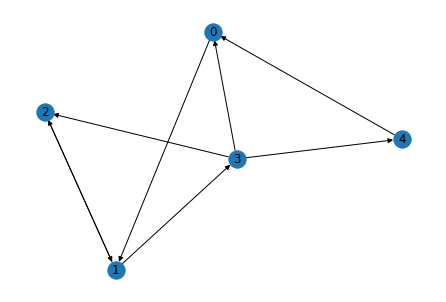

In [10]:
G = nx.DiGraph()
nodes = [i for i in range(0, 5)]
edges = [(0, 1), (1, 2), (1, 3), (2, 1), (3, 0), (3, 2), (3, 4), (4, 0)]
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

In [11]:
G, initial_node_points = initialize_node_points(G)
pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points)
pageranks_array = np.array(pageranks)


print("Iteration counter:", iteration_counter)
print("Pageranks:", pageranks_array)

Iteration counter: 21
Pageranks: [0.1250008  0.3749975  0.25000085 0.1875021  0.06249875]


### 1.3 Проблемы подхода

#### Тупиковые узлы

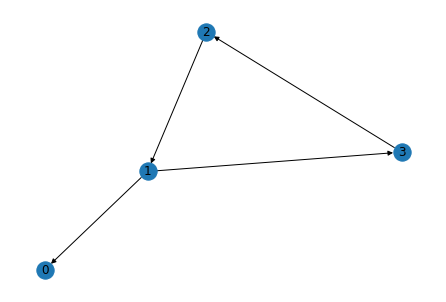

In [12]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(1, 3), (3, 2), (2, 1), (1, 0)])
nx.draw(G, with_labels=True)

Тупиковые узлы поглощают случайного посетителя и устанавливают PageRank других страниц равным 0. Чтобы избежать этого результата, мы добавляем виртуальные ребра, направленные от этих узлов ко всем остальным узлам. С этой настройкой random surfer, застрявший в узлах приемника, может случайным образом переходить на другие страницы. Матрица перехода для приведенного выше графа:

$$M = \begin{pmatrix}
0 & 1/2 & 0 & 0\\
1/3 & 0 & 1 & 0\\
1/3 & 0 & 0 & 1\\
1/3 & 1/2 & 0 & 0\\
\end{pmatrix}$$

#### Изолированные компоненты графа

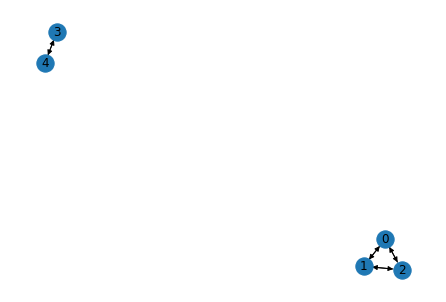

In [13]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (4, 3), (3, 4)])
nx.draw(G, with_labels=True)

В таких случаях матрица перехода является блочно-диагональной и имеет несколько линейно независимых собственных векторов, соответствующих собственному значению 1.

In [14]:
calculate_transition_matrix(G)

array([[0. , 0.5, 0.5, 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. , 0. ]])

Чтобы решить эту проблему, создатели PageRank представили damping factor *d*

$$M = (1-d)M + \frac{d}{n}J_n$$
 
где n - количество узлов и $J_n$ - является матрицей единиц. Эта переформулированная матрица перехода также называется Google матрицей. Матрица Google делает все связанные узлы и векторы PageRank уникальными для веб-графов. Это также решает циклический серфинг, который делает нереальным power method. Интуитивно, damping factor позволяет скучающему случайному посетителю перейти на другую случайную страницу с вероятностью d.

### 1.4 Подсчёт PageRank

Выше мы увидели, что итеративный расчет PageRank эквивалентен вычислению собственного вектора, соответствующего собственному значению 1. Но могут возникнуть некоторые вопросы. Всегда ли Google матрица перехода имеет собственное значение 1 кратности один? Всегда ли итеративный расчет сходится к уникальному вектору? Насколько быстро происходит сходимость? Для ответа на эти вопросы воспользуемся теоремой:

**Теорема Фробениуса-Перрона** (доказательство [здесь](https://sites.math.northwestern.edu/~clark/354/2002/perron.pdf))

Если матрица $M$ положительна и поколоночно стахостична, то:

1. $M$ имеет собственное значение 1 единичной кратности
2. 1 — наибольшее собственное значение: все остальные собственные значения имеют абсолютные значения меньше 1
3. Для собственного значения 1 существует единственный собственный вектор, сумма элементов которого равна 1

Говоря проще, нам нужно только вычислить собственный вектор для собственного значения 1, чтобы получить PageRank. Найти такой собственный вектор можно при помощи **power method** или **собственного разложения** матрицы. **Power method** заключается в том, что для фиксированной матрицы $M$ и начального приближения $v_0$ нужно умножать вектор на матрицу, пока значения в векторе не перестанут меняться.

### 1.5 Реализация

In [15]:
def get_google_matrix(G, d=0.15):
    n = G.number_of_nodes()
    A = nx.to_numpy_array(G).T
    # for sink nodes
    is_sink = np.sum(A, axis=0) == 0
    B = (np.ones_like(A) - np.identity(n)) / (n - 1)
    A[:, is_sink] += B[:, is_sink]

    D_inv = np.diag(1 / np.sum(A, axis=0))
    M = np.dot(A, D_inv)

    # for disconnected components
    M = (1 - d) * M + d * np.ones((n, n)) / n
    return M


def l1(x):
    return np.sum(np.abs(x))

Первое решение — собственное разложение матрицы Google. L1-нормированный собственный вектор, соответствующий наибольшему собственному значению (=1) — вектор PageRank.

In [16]:
def pagerank_edc(G, d=0.15):
    M = get_google_matrix(G, d=d)
    eigenvalues, eigenvectors = np.linalg.eig(M)
    idx = eigenvalues.argsort()[-1]
    largest = np.array(eigenvectors[:, idx]).flatten().real
    return largest / l1(largest)

In [17]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(1, 3), (3, 2), (2, 1), (1, 0), (0, 1)])
pagerank_edc(G)

array([0.20195025, 0.38694178, 0.20915772, 0.20195025])

Какая сложность у алгоритма? 
Алгоритмическая сложность $O(n^3)$, поскольку собственное разложение является вычислительно сложной операцией. Такое решение с более чем одним триллионом вершин (веб-страниц) получится слишком дорогим.

### Power Method

Метод инициализирует вектор $v_0$ из равномерного распределения и итеративно умножает его матрицу Google, пока значения в векторе не сойдутся или алгоритм не достигнет максимального количества итераций.

In [18]:
def pagerank_power(G, d=0.15, max_iter=100, eps=1e-9):
    M = get_google_matrix(G, d=d)
    n = G.number_of_nodes()
    V = np.ones(n) / n
    for _ in range(max_iter):
        V_last = V
        V = np.dot(M, V)
        if l1(V - V_last) / n < eps:
            return V
    return V

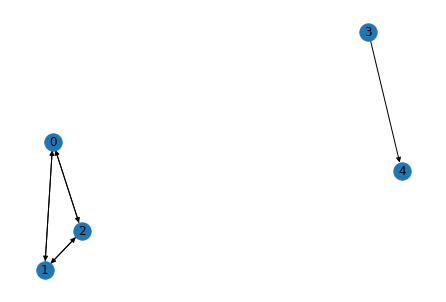

In [19]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (3, 4)])
nx.draw(G, with_labels=True)

In [20]:
pagerank_power(G)

array([0.29595728, 0.29595728, 0.29595728, 0.04439359, 0.06773455])

Что касается сложности, в этом алгоритме самым сложным является умножение матрицы на вектор, поскольку количество итераций ограничено max_iter. Следовательно, временная сложность $O(n^2)$. Сложность можно свести к $O(n)$, если использовать разреженное матричного умножения. Напоминаем, что матрица Google — это взвешенная сумма матрицы перехода (разреженной!) и матрицы единиц (просто оператора суммы).

In [21]:
def gen_webgraph(n, m):
    G = nx.DiGraph(nx.barabasi_albert_graph(n, m))
    rands = np.random.choice(n, n // 2, replace=False)
    G.remove_edges_from(np.array(G.edges)[rands])
    return G

In [22]:
number_of_nodes = range(100, 1600, 200)
times_edc = []
times_power = []
for n in number_of_nodes:
    G = gen_webgraph(n, 50)

    st = time.time()
    pagerank_edc(G)
    times_edc.append(time.time() - st)

    st = time.time()
    pagerank_power(G)
    times_power.append(time.time() - st)

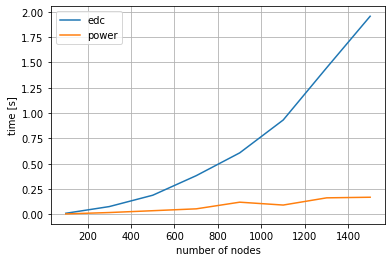

In [23]:
plt.grid()
plt.plot(list(number_of_nodes), times_edc, label="edc")
plt.plot(list(number_of_nodes), times_power, label="power")
plt.xlabel("number of nodes")
plt.ylabel("time [s]")
plt.legend()
plt.show()

Как можем видеть, power method быстрее, чем собственное разложение, особенно когда у нас много узлов.

Есть некоторые расширения, такие как Personalized PageRank, который использует распределения, предвзятые для каждого пользователя, вместо равномерного распределения $J_n$ для расчета Google матрицы.

In [24]:
def pagerank_with_personalization(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
):
    if len(G) == 0:
        return {}

    D = G.to_directed()

    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()

    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = sum(nstart.values())
        x = {k: v / s for k, v in nstart.items()}

    if personalization is None:
        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        s = sum(personalization.values())
        p = {k: v / s for k, v in personalization.items()}

    if dangling is None:
        # Use personalization vector if dangling vector not specified
        dangling_weights = p
    else:
        s = sum(dangling.values())
        dangling_weights = {k: v / s for k, v in dangling.items()}
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            # this matrix multiply looks odd because it is
            # doing a left multiply x^T=xlast^T*W
            for _, nbr, wt in W.edges(n, data=weight):
                x[nbr] += alpha * xlast[n] * wt
            x[n] += danglesum * dangling_weights.get(n, 0) + (1.0 - alpha) * p.get(n, 0)
        # check convergence, l1 norm
        err = sum(abs(x[n] - xlast[n]) for n in x)
        if err < N * tol:
            return x

{0: 0.1724140124772394,
 1: 0.3275859875227606,
 2: 0.3275859875227606,
 3: 0.1724140124772394}

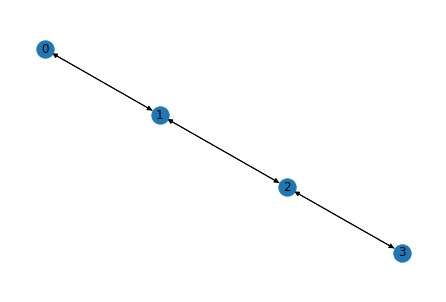

In [25]:
G = nx.DiGraph(nx.path_graph(4))

nx.draw(G, with_labels=True)
nx.pagerank(G, alpha=0.9)

## 2. GraphSAGE

В этой секции поговорим о графовых свёрточных сетях для классификации вершин.

В GCN (Graph Convolution Network) "свертка" — это почти та же операция: умножение входных нейронов на набор весов, которые обычно известны как фильтры или ядра. Фильтры действуют как скользящие окна по всему изображению и позволяют CNN изучать эмбеддинги из соседних клеток. В том же слое один и тот же фильтр будет использоваться по всему изображению. Например, используя CNN для классификации изображений кошек и не кошек, один и тот же фильтр слоя будет использоваться для обнаружения носа и ушей кошки. GCN выполняют аналогичные операции, когда модель изучает особенности, проверя соседние узлы. Основное различие между CNN и GNN заключается в том, что CNN специально построены для работы с обычными структурированными данными, в то время как GNN являются их обобщенной версией, где количество рёбер варьируется, а вершины не упорядочены.

[![1.jpg](https://i.postimg.cc/mkxWbctf/1.jpg)](https://postimg.cc/G8j5KmFq)
Иллюстрация 2D сверточных нейронных сетей и графических сверточных сетей.

[источник](https://arxiv.org/pdf/1901.00596.pdf)

В ячейках ниже реализуем слой **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) напрямую. Затем мы запустим наши модели в наборе данных CORA, который является стандартным набором данных для анализа графов. В этом датасете примерно 2700 статей и около 5500 ссылок между ними. Все статьи разбиты на 7 классов.

In [26]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu111.html
# !pip install torch-geometric
# !pip install git+ssh://git@github.com/snap-stanford/deepsnap.git

In [27]:
import copy

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
import torch_scatter
from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.nn.conv import MessagePassing
from tqdm import trange

Ниже приведена реализация общего модуля GNN, куда мы можем подключить любой слой GNN.

In [28]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super().__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert args.num_layers >= 1, "Number of layers is not >=1"
        for l in range(args.num_layers - 1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim),
        )

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == "GraphSage":
            return GraphSage
        elif model_type == "Conv":
            return torch_geometric.nn.GCNConv
        else:
            raise Exception("Not implemented!")

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Теперь приступим к реализации наших собственных Message Passing слоев. Для этого мы будем работать и реализовывать 3 функции, необходимые для передачи и обработки сообщений: `forward`, `message`, и `aggregate`.

Пройдемся по ключевым компонентам процесса передачи сообщений. Для этого мы сосредоточимся на передаче сообщений относительно одной центральной вершины $x$. Перед передачей сообщения $x$ связывается с вектором признаков $x^{l-1}$, и целью передачи сообщения является обновление этого вектора признаков как $x^l$. Для этого реализуем следующие шаги:
1. Каждый соседний узел $v$ передает свое текущее сообщение $v^{l-1}$ через ребро $(x, v)$.
2. Для узла $x$ мы объединяем все сообщения соседних узлов (например, через сумму или среднее значение).
3. Преобразуем агрегированную информацию, например, применяя линейные и нелинейные преобразования. В целом процесс передачи сообщений применяется таким образом, что каждый узел $u$ в нашем графе обновляет свое вложение, действуя как центральный узел $x$ на шагах 1-3, описанных выше.

Теперь, расширив этот процесс до одного уровня передачи сообщений, задача уровня передачи сообщений заключается в обновлении текущего представления функций или внедрении каждой вершины в граф путем распространения и преобразования информации в графе. В целом, общая парадигма уровней передачи сообщений: 1) предварительная обработка -> 2) **передача сообщения**/распространение -> 3) постобработка.

Функция `propagate` инкапсулирует процесс передачи сообщения. Она делает это, вызывая три функции: 1) `message`, 2)  `aggregate`, и 3) `update`. Наша реализация будет немного отличаться от этой, так как мы не будем явно реализовывать `update`, а вместо этого поместим логику для обновления эмбеддингов узлов после передачи сообщения и внутри функции `forward`. После передачи сообщения мы можем дополнительно преобразовать вложения узлов, полученные с помощью `propagate`. И так, выходы из `forward` — это эмбеддинги вершин после одного слоя GNN.


Обсудим подробнее:

1. 

```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
Вызов `propagate` инициирует процесс передачи сообщения. Глядя на параметры функции, мы выделим пару ключевых параметров.

   - `edge_index` передается forward функции и получает структуру ребер графа.
   - `x=(x_i, x_j)` представляет эмбеддинги вершин, которые будут использоваться при передаче сообщений. Чтобы объяснить, почему мы передаем `(x_i, x_j)`, мы сначала посмотрим, как представлены наши ребра. Для каждого ребра $(i, j) \in \mathcal{E}$ мы можем дифференцировать $i$ как исходный или центральный узел ($x_{central}$) и j как соседний узел ($x_{neighbor}$).
   
Взяв пример передачи сообщений выше, для центрального узла $u$ мы будем агрегировать и преобразовывать все сообщения, связанные с узлами $v$ и т.д.  $(u, v) \in \mathcal{E}$ (т. е. $v \in \mathcal{N}_{u}$). Таким образом, мы видим, что индексы `_i` и `_j` позволяют нам конкретно различать эмбеддинги, связанные с центральными узлами (т. е. узлами, получающими информацию о сообщениях) и соседними узлами (т. е. узлами, передающими сообщения).

Одна ключевая вещь, которую следует понимать, заключается в том, что в зависимости от точки зрения узел $x$ действует как центральный узел или соседний узел. Фактически, в неориентированных графах мы храним оба направления ребер (т. е. $(i, j)$ и $(j, i)$). С точки зрения центрального узла, `x_i`, x собирает соседнюю информацию для обновления своего внедрения. С точки зрения соседнего узла, `x_j`, x передает информацию о своем сообщении вдоль ребра, соединяющего его с другим центральным узлом.

  - `extra=(extra_i, extra_j)` представляет дополнительную информацию, которую мы можем связать с каждым узлом помимо его текущего внедрения функций. На самом деле, мы можем включить столько дополнительных параметров вида `param=(param_i, param_j)`, сколько захотим. Опять же, мы подчеркиваем, что индексирование с помощью `_i` и `_j` позволяет нам различать центральные и соседние узлы.

  Выход функции `propagate` представляет собой матрицу эмбеддингов вершин после процесса передачи сообщения и имеет форму $[N, d]$.

2. 
```
def message(x_j, ...):
```
Функция `message` вызывается функцией propagate и создает сообщения из соседних вершин $j$ с центральными узлами $i$ для каждого ребра $(i, j)$ в *edge_index*. Эта функция может принимать любой аргумент, который изначально был передан в функцию `propagate`. Кроме того, мы снова можем различать центральные узлы и соседние узлы, добавляя `_i` или `_j` к имени переменной, т.е. `x_i` и `x_j`. Глядя более конкретно на переменные, мы имеем:

   - `x_j` представляет собой матрицу эмбеддингов признаков для всех соседних узлов, передающих свои сообщения по соответствующему ребру (т. е. все узлы $j$ для рёбер $(i, j) \in \mathcal{E}$). Таким образом, его форма равна $[|\mathcal{E}|, d]$!

  Важно, что выход `message` функции представляет собой матрицу эмбеддингов соседних узлов, готовую к агрегированию, имеющую форму $[|\mathcal{E}|, d]$.

3. 
```
def aggregate(self, inputs, index, dim_size = None):
```
Наконец, функция `aggregate` используется для агрегирования сообщений от соседних вершин:

   - `inputs` представляют собой матрицу сообщений, переданных от соседних узлов (т.е. вывод функции `message`).
   - `index` имеет ту же форму, что и `inputs`, и сообщает нам центральный узел, соответствующий каждой из строк/сообщений $j$ в матрице `inputs`. Таким образом, `index` говорит нам, какие строки/сообщения агрегировать для каждого центрального узла.

   Выход `aggregate` имеет форму $[N, d]$.
   
Дополнительные ресурсы см. в документации PyG для реализации своих Message Passing слоев: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html.

Теперь реализуем свой слой GraphSage.

Для данного *центрального* узла $v$ с текущим эмбеддингом $h_v^{l-1}$ правило обновления передачи сообщений для преобразования $h_v^{l-1} \rightarrow h_v^l$ выглядит следующим образом:

\begin{equation}
h_v^{(l)} = W_1\cdot h_v^{(l-1)} + W_2 \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

где $W_1$ и $W_2$ — обучаемые матрицы весов, а узлы $u$ — *соседние* узлы. Кроме того, для простоты мы используем среднее агрегирование:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Следует отметить, что мы добавляем **skip connections** в нашу реализацию GraphSage через $W_1\cdot h_v^{(l-1)}$.

Наконец, после каждой итерации применяется $L_2$ нормализация эмбеддингов вершин.

In [29]:
class GraphSage(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize=True, bias=False, **kwargs):
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size=None):
        # x is shape (N, in_c)
        neighbor_out = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(neighbor_out)
        if self.normalize:
            out = torch.nn.functional.normalize(out, p=2)

        return out

    def message(self, x_j):
        # x_j has shape (E, d)
        out = x_j
        return out

    def aggregate(self, inputs, index):
        node_dim = self.node_dim

        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce="mean")

        return out

In [30]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p: p.requires_grad, params)
    if args.opt == "adam":
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == "sgd":
        optimizer = optim.SGD(
            filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay
        )
    elif args.opt == "rmsprop":
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == "adagrad":
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler is None:
        return None, optimizer
    elif args.opt_scheduler == "step":
        scheduler = optim.lr_scheduler.StepLR(
            optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate
        )
    elif args.opt_scheduler == "cos":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=args.opt_restart
        )
    return scheduler, optimizer

### Обучение GNN

In [31]:
def train(dataset, args):

    print("Node task. test set size:", np.sum(dataset[0]["test_mask"].numpy()))
    print()
    test_loader = loader = DataLoader(
        dataset, batch_size=args.batch_size, shuffle=False
    )

    # build model
    model = GNNStack(
        dataset.num_node_features, args.hidden_dim, dataset.num_classes, args
    )
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            test_accs.append(test_acc)
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = copy.deepcopy(model)
        else:
            test_accs.append(test_accs[-1])

    return test_accs, losses, best_model, best_acc, test_loader


def test(
    loader, test_model, is_validation=False, save_model_preds=False, model_type=None
):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
            print("Saving Model Predictions for Model Type", model_type)

            data = {}
            data["pred"] = pred.view(-1).cpu().detach().numpy()
            data["label"] = label.view(-1).cpu().detach().numpy()

            df = pd.DataFrame(data=data)
            # Save locally as csv
            df.to_csv("CORA-Node-" + model_type + ".csv", sep=",", index=False)

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total


class ObjectView(object):
    def __init__(self, d):
        self.__dict__ = d

In [32]:
args = {
    "model_type": "GraphSage",
    "dataset": "cora",
    "num_layers": 2,
    "heads": 1,
    "batch_size": 32,
    "hidden_dim": 32,
    "dropout": 0.5,
    "epochs": 500,
    "opt": "adam",
    "opt_scheduler": None,
    "opt_restart": 0,
    "weight_decay": 5e-3,
    "lr": 0.01,
}

In [33]:
args = ObjectView(args)

Processing...
Done!
/usr/local/anaconda3/envs/ml/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:55<00:00,  8.98Epochs/s]


Maximum test set accuracy: 0.801
Minimum loss: 0.10902104526758194
Saving Model Predictions for Model Type GraphSage



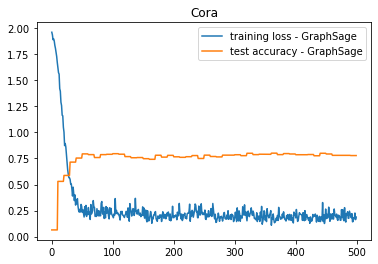

In [34]:
model = "GraphSage"
if args.dataset == "cora":
    dataset = Planetoid(root="/tmp/cora", name="Cora")
else:
    raise NotImplementedError("Unknown dataset")
test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

print(f"Maximum test set accuracy: {max(test_accs):.2f}")
print(f"Minimum loss: {min(losses):.2f}")

# Run test for our best model to save the predictions!
test(
    test_loader,
    best_model,
    is_validation=False,
    save_model_preds=True,
    model_type=model,
)
print()

plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:01<00:00,  8.18Epochs/s]


Maximum test set accuracy: 0.791
Minimum loss: 0.05604475736618042
Saving Model Predictions for Model Type Conv



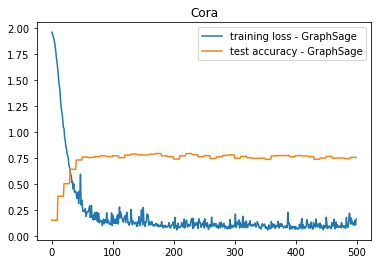

In [35]:
args = {
    "model_type": "GraphSage",
    "dataset": "cora",
    "num_layers": 4,
    "heads": 1,
    "batch_size": 32,
    "hidden_dim": 32,
    "dropout": 0.3,
    "epochs": 500,
    "opt": "adam",
    "opt_scheduler": None,
    "opt_restart": 0,
    "weight_decay": 5e-3,
    "lr": 0.01,
}
args = ObjectView(args)
model = "Conv"
if args.dataset == "cora":
    dataset = Planetoid(root="/tmp/cora", name="Cora")
else:
    raise NotImplementedError("Unknown dataset")
test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# Run test for our best model to save the predictions!
test(
    test_loader,
    best_model,
    is_validation=False,
    save_model_preds=True,
    model_type=model,
)
print()

plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()